## 콜센터 데이터 감성분석

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import f_oneway, kruskal, levene, shapiro

from konlpy.tag import Okt
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from wordcloud import WordCloud

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


In [2]:
df = pd.read_excel('insurance_filtered.xlsx')

In [3]:
len(df)

3671

In [4]:
df.head(10)

,도메인,카테고리,대화셋일련번호,화자,문장번호,고객의도,상담사의도,QA,고객질문(요청),상담사질문(요청),고객답변,상담사답변,개체명,용어사전,지식베이스,필터용
0,금융/보험,상품 가입 및 해지,A5139,고객,1,보험해지,NaN,Q,보험계약을 해지 하고 싶은데요?,NaN,NaN,NaN,보험계약 해지,보험가입/ 계약/ 보험해지,"보험계약해지,보험해지",보험해지
1,금융/보험,상품 가입 및 해지,A5139,상담사,2,NaN,보험해지,Q,NaN,네. 계약해지에 대해 안내해 드릴까요?,NaN,NaN,"계약, 해지",보험가입/ 계약/ 보험해지,"해지,보험해지",보험해지
2,금융/보험,상품 가입 및 해지,A5139,고객,3,보험해지,NaN,Q,계약을 중도해지할때 내야 하는 세금에 대해 알고싶어요,NaN,NaN,NaN,"계약, 중도해지, 세금",보험가입/ 계약/ 보험해지,"중도해지,보험해지",보험해지
3,금융/보험,상품 가입 및 해지,A5139,상담사,4,NaN,보험해지,Q,NaN,해지하려고 하시는 보험이 저축성 또는 보장성 보험인가요?,NaN,NaN,"해지, 저축성보험, 보장성 보험",보험가입/ 계약/ 보험해지,"저축성보험,보험해지",보험해지
4,금융/보험,상품 가입 및 해지,A5139,고객,5,보험해지,NaN,A,NaN,NaN,어떤 상품인지 정확히 모르겠어요,NaN,보험상품,보험/ 상품,"보험상품,상품",보험해지
5,금융/보험,상품 가입 및 해지,A5139,상담사,6,NaN,보험해지,Q,NaN,네 그럼 일반 저축성 보장성 보험 해지시 내야하는 세금에 대해 안내해 드릴까요?,NaN,NaN,"해지, 저축성보험, 보장성 보험,세금",해지/ 저축성보험/ 보장성 보험/세금,"저축성보험,세금",보험해지
6,금융/보험,상품 가입 및 해지,A5139,고객,7,보험해지,NaN,A,NaN,NaN,네 그렇게 해주세요.,NaN,NaN,NaN,NaN,보험해지
7,금융/보험,상품 가입 및 해지,A5139,상담사,8,NaN,보험해지,Q,NaN,그럼 고객님 해지환급금이 납입한 보험료 보다 많으신가요?,NaN,NaN,"해지환급금, 납입보험료",보험해지/ 보험료/ 납입,"납입보험료,납입",보험해지
8,금융/보험,상품 가입 및 해지,A5139,고객,9,보험해지,NaN,A,NaN,NaN,네 많아요,NaN,NaN,NaN,NaN,보험해지
9,금융/보험,상품 가입 및 해지,A5139,상담사,10,NaN,보험해지,A,NaN,NaN,NaN,네. 그러시다면 해지환급금과 납입한 보험료 차액에 대해 이자소득세 15.4%가 부과...,"납입보험료, 해지환급금. 이자소득세",보험료/ 해지환급금/ 세금,"해지환급금.이자소득세,세금",보험해지


In [5]:
# 1. 고객 발화만 필터링
customer_df = df[df['화자'] == '고객'].copy()

# 2. 고객 질문 + 답변 컬럼을 합쳐 하나의 문장으로
customer_df["고객문장"] = customer_df["고객질문(요청)"].fillna('') + " " + customer_df["고객답변"].fillna('')
customer_df["고객문장"] = customer_df["고객문장"].str.strip()  # 양쪽 공백 제거

# 3. 감성분석에 사용할 텍스트만 있는 DataFrame 미리 확인
display(customer_df[["대화셋일련번호", "문장번호", "고객문장"]].head())

,대화셋일련번호,문장번호,고객문장
0,A5139,1,보험계약을 해지 하고 싶은데요?
2,A5139,3,계약을 중도해지할때 내야 하는 세금에 대해 알고싶어요
4,A5139,5,어떤 상품인지 정확히 모르겠어요
6,A5139,7,네 그렇게 해주세요.
8,A5139,9,네 많아요


In [5]:
# 모델 로드
model_name = "nlp04/korean_sentiment_analysis_dataset3_best"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 감성 점수 계산 함수
def get_sentiment_score(text):
    if not text or pd.isna(text.strip()):
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze()
    # 클래스 인덱스에 따라 점수 매핑 (예: 0: 부정, 1: 중립, 2: 긍정)
    score = -1 * probs[0].item() + 0 * probs[1].item() + 1 * probs[2].item()
    return round(score, 3)

# 데이터프레임에 적용
tqdm.pandas()
customer_df["감성점수"] = customer_df["고객문장"].progress_apply(get_sentiment_score)

# C:\Users\Lenovo\.cache\huggingface\ 여기에 저장된다고..
# # Hugging Face 캐시 전체 삭제
# rm -rf ~/.cache/huggingface

100%|██████████| 1871/1871 [2:01:59<00:00,  3.91s/it]      


In [6]:
customer_df

,도메인,카테고리,대화셋일련번호,화자,문장번호,고객의도,상담사의도,QA,고객질문(요청),상담사질문(요청),고객답변,상담사답변,개체명,용어사전,지식베이스,필터용,고객문장,감성점수
0,금융/보험,상품 가입 및 해지,A5139,고객,1,보험해지,NaN,Q,보험계약을 해지 하고 싶은데요?,NaN,NaN,NaN,보험계약 해지,보험가입/ 계약/ 보험해지,"보험계약해지,보험해지",보험해지,보험계약을 해지 하고 싶은데요?,-0.099
2,금융/보험,상품 가입 및 해지,A5139,고객,3,보험해지,NaN,Q,계약을 중도해지할때 내야 하는 세금에 대해 알고싶어요,NaN,NaN,NaN,"계약, 중도해지, 세금",보험가입/ 계약/ 보험해지,"중도해지,보험해지",보험해지,계약을 중도해지할때 내야 하는 세금에 대해 알고싶어요,-0.355
4,금융/보험,상품 가입 및 해지,A5139,고객,5,보험해지,NaN,A,NaN,NaN,어떤 상품인지 정확히 모르겠어요,NaN,보험상품,보험/ 상품,"보험상품,상품",보험해지,어떤 상품인지 정확히 모르겠어요,-0.860
6,금융/보험,상품 가입 및 해지,A5139,고객,7,보험해지,NaN,A,NaN,NaN,네 그렇게 해주세요.,NaN,NaN,NaN,NaN,보험해지,네 그렇게 해주세요.,-0.788
8,금융/보험,상품 가입 및 해지,A5139,고객,9,보험해지,NaN,A,NaN,NaN,네 많아요,NaN,NaN,NaN,NaN,보험해지,네 많아요,-0.776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,금융/보험,상품 가입 및 해지,A34684,고객,11,보험해지,NaN,A,NaN,NaN,네. 지금 당장 해지해 주세요.,NaN,"지금, 당장, 해지","지금, 당장, 해지","당장,해지",보험해지,네. 지금 당장 해지해 주세요.,-0.613
3663,금융/보험,상품 가입 및 해지,A34684,고객,13,보험해지,NaN,Q,요즘 전화로 해지가 안되는 것도 있나요?,NaN,NaN,NaN,"요즘, 전화, 해지","요즘, 전화, 해지","전화,해지",보험해지,요즘 전화로 해지가 안되는 것도 있나요?,-0.162
3665,금융/보험,상품 가입 및 해지,A34684,고객,15,보험해지,NaN,A,NaN,NaN,계약 할때는 어디든 오더니 좀 그러네요,NaN,계약,계약,계약,보험해지,계약 할때는 어디든 오더니 좀 그러네요,-0.045
3667,금융/보험,상품 가입 및 해지,A34684,고객,17,보험해지,NaN,Q,그럼 어디로 가면 되요?,NaN,NaN,NaN,NaN,NaN,NaN,보험해지,그럼 어디로 가면 되요?,-0.737


In [7]:
customer_df[customer_df["대화셋일련번호"] == "A29674"]

,도메인,카테고리,대화셋일련번호,화자,문장번호,고객의도,상담사의도,QA,고객질문(요청),상담사질문(요청),고객답변,상담사답변,개체명,용어사전,지식베이스,필터용,고객문장,감성점수
2746,금융/보험,상품 가입 및 해지,A29674,고객,1,보험해지,NaN,Q,제가 보험을 해지하려고 하는데 해약환급금이 얼마인지 궁금합니다.,NaN,NaN,NaN,보험/해지/해약환급금,"해지/해약, 해지환급금/금액","해지,금액",보험해지,제가 보험을 해지하려고 하는데 해약환급금이 얼마인지 궁금합니다.,-0.142
2748,금융/보험,상품 가입 및 해지,A29674,고객,3,보험해지,NaN,A,NaN,NaN,네.,NaN,NaN,NaN,NaN,보험해지,네.,-0.863
2750,금융/보험,상품 가입 및 해지,A29674,고객,5,보험해지,NaN,A,NaN,NaN,네.,NaN,NaN,NaN,NaN,보험해지,네.,-0.863
2752,금융/보험,상품 가입 및 해지,A29674,고객,7,보험해지,NaN,A,NaN,NaN,OOO이요.,NaN,OOO,NaN,OOO,보험해지,OOO이요.,-0.730
2754,금융/보험,상품 가입 및 해지,A29674,고객,9,보험해지,NaN,A,NaN,NaN,OOO-OOOO-OOOO이요.,NaN,OOO-OOOO-OOOO,NaN,OOO-OOOO-OOOO,보험해지,OOO-OOOO-OOOO이요.,-0.587
2756,금융/보험,상품 가입 및 해지,A29674,고객,11,보험해지,NaN,A,NaN,NaN,네. 맞아요.,NaN,NaN,NaN,NaN,보험해지,네. 맞아요.,-0.833
2758,금융/보험,상품 가입 및 해지,A29674,고객,13,보험해지,NaN,Q,아~그래요? 그런데 해지 환급금이 왜 제가 넣은 돈보다 적나요?,NaN,NaN,NaN,해지환급금/돈,해지환급금/금액,"돈,금액",보험해지,아~그래요? 그런데 해지 환급금이 왜 제가 넣은 돈보다 적나요?,0.469
2760,금융/보험,상품 가입 및 해지,A29674,고객,15,보험해지,NaN,Q,그래요? 근데 무슨 사업비가 든다는 거에요?,NaN,NaN,NaN,사업비,사업비/비용,"사업비,비용",보험해지,그래요? 근데 무슨 사업비가 든다는 거에요?,-0.107
2762,금융/보험,상품 가입 및 해지,A29674,고객,17,보험해지,NaN,Q,아니 그럼 사업비가 그렇게 많이 든다는 거에요?,NaN,NaN,NaN,사업비,사업비/비용,"사업비,비용",보험해지,아니 그럼 사업비가 그렇게 많이 든다는 거에요?,0.011
2764,금융/보험,상품 가입 및 해지,A29674,고객,19,보험해지,NaN,A,NaN,NaN,네. 알겠습니다.,NaN,NaN,NaN,NaN,보험해지,네. 알겠습니다.,-0.822


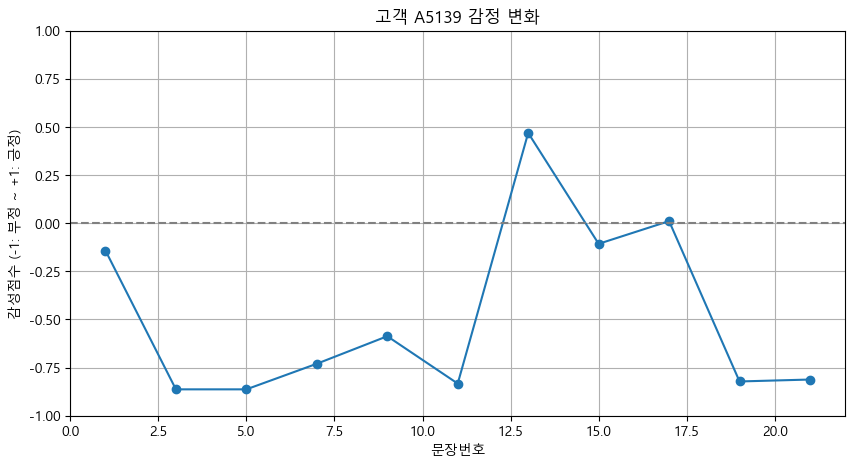

In [8]:
# 예시: A5139 고객 발화만 선택
subset = customer_df[customer_df["대화셋일련번호"] == "A29674"]

plt.figure(figsize=(10, 5))
plt.plot(subset["문장번호"], subset["감성점수"], marker='o', linestyle='-')
plt.title("고객 A5139 감정 변화")
plt.xlabel("문장번호")
plt.ylabel("감성점수 (-1: 부정 ~ +1: 긍정)")
plt.grid(True)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')  # 중립선
plt.show()


In [9]:
subset["감성변화량"] = subset["감성점수"].diff().abs()

# 감정 변화 큰 부분 상위 3개 확인
subset.nlargest(3, "감성변화량")[["문장번호", "고객문장", "감성점수", "감성변화량"]]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24112\629904368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["감성변화량"] = subset["감성점수"].diff().abs()


,문장번호,고객문장,감성점수,감성변화량
2758,13,아~그래요? 그런데 해지 환급금이 왜 제가 넣은 돈보다 적나요?,0.469,1.302
2764,19,네. 알겠습니다.,-0.822,0.833
2748,3,네.,-0.863,0.721


In [10]:
def summarize_sentiment(df):
    df_sorted = df.sort_values("문장번호")
    감성점수 = df_sorted["감성점수"].reset_index(drop=True)
    
    # 변화량
    변화량 = 감성점수.diff()
    
    # 감정 반전이 일어난 지점만 필터
    반전마스크 = (감성점수 * 감성점수.shift(1)) < 0
    반전폭 = 변화량[반전마스크].abs()
    
    return pd.Series({
        "감성_평균": 감성점수.mean(),
        "감성_최종값": 감성점수.iloc[-1],
        "감성_변화량합": 감성점수.diff().abs().sum(),
        "감정반전횟수": 반전마스크.sum(),
        "최대감정반전폭": round(반전폭.max() if not 반전폭.empty else 0, 3)
    })

summary_df = customer_df.groupby("대화셋일련번호").apply(summarize_sentiment).reset_index()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24112\3575238742.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = customer_df.groupby("대화셋일련번호").apply(summarize_sentiment).reset_index()


In [11]:
summary_df

,대화셋일련번호,감성_평균,감성_최종값,감성_변화량합,감정반전횟수,최대감정반전폭
0,A11383,-0.523444,-0.552,2.200,0.0,0.000
1,A11384,-0.526000,-0.592,1.398,0.0,0.000
2,A11402,-0.465125,-0.630,2.527,0.0,0.000
3,A11460,-0.498200,-0.552,2.155,0.0,0.000
4,A11493,-0.477200,-0.020,2.224,0.0,0.000
...,...,...,...,...,...,...
222,A8508,-0.552750,-0.764,2.666,0.0,0.000
223,A8731,-0.629111,-0.583,1.045,0.0,0.000
224,A8947,-0.580091,-0.737,1.933,0.0,0.000
225,A8948,-0.543100,-0.567,1.771,0.0,0.000


In [12]:
summary_df[['대화셋일련번호','최대감정반전폭']].sort_values(by='최대감정반전폭',ascending=False)

,대화셋일련번호,최대감정반전폭
109,A29674,1.302
203,A7649,1.249
110,A29675,1.190
187,A5975,1.146
154,A34643,1.140
...,...,...
105,A29549,0.000
106,A29551,0.000
107,A29597,0.000
33,A17296,0.000


In [13]:
summary_df[['대화셋일련번호','감정반전횟수']].sort_values(by='감정반전횟수',ascending=False)

,대화셋일련번호,감정반전횟수
187,A5975,6.0
207,A7939,5.0
205,A7905,5.0
226,A8957,4.0
162,A5448,4.0
...,...,...
93,A19827,0.0
94,A28133,0.0
95,A28137,0.0
97,A28173,0.0


In [14]:
summary_df[['대화셋일련번호','감성_최종값']].sort_values(by='감성_최종값',ascending=False)

,대화셋일련번호,감성_최종값
212,A8130,0.083
93,A19827,0.070
86,A19284,0.052
204,A7894,0.008
166,A5452,-0.003
...,...,...
113,A29764,-0.863
103,A29062,-0.872
106,A29551,-0.872
144,A33571,-0.872


In [15]:
# 감성점수 있는 customer_df에서 필요한 컬럼만 추출
감성점수_데이터 = customer_df[["대화셋일련번호", "문장번호", "감성점수"]]

# df에 감성점수 붙이기 (left join)
df_merged = df.merge(감성점수_데이터, on=["대화셋일련번호", "문장번호"], how="left")

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# 0. 데이터 전처리
df = df_merged.copy()
df['감성점수'] = pd.to_numeric(df['감성점수'], errors='coerce')
df['고객전체발화'] = df['고객질문(요청)'].fillna('') + df['고객답변'].fillna('')
df['상담사전체발화'] = df['상담사질문(요청)'].fillna('') + df['상담사답변'].fillna('')

# 1. 고객 감성점수 기준 Top-N 낮은 발화 선택
N = 20  # 필요시 조정
lowest_emotion = df[
    (df['화자'] == '고객') & 
    (df['감성점수'].notnull())
].sort_values('감성점수').head(N)

# 2. 해당 발화들이 포함된 대화셋 전체 발화 추출
target_dialog_ids = lowest_emotion['대화셋일련번호'].unique()
dialog_subset = df[df['대화셋일련번호'].isin(target_dialog_ids)]

# 3. 상담사 발화 텍스트만 추출
counselor_texts = dialog_subset[
    (dialog_subset['화자'] == '상담사') & 
    (dialog_subset['상담사전체발화'].notnull())
]['상담사전체발화'].tolist()

# 4. 텍스트 특징 추출 (Count 기반)
vectorizer = CountVectorizer(stop_words='english')  # 필요시 한국어 토크나이저 교체
X = vectorizer.fit_transform(counselor_texts)
word_freq = X.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()
word_freq_pairs = sorted(zip(vocab, word_freq), key=lambda x: x[1], reverse=True)

# 5. 상위 단어 N개 보기
top_n = 30
top_words_df = pd.DataFrame(word_freq_pairs[:top_n], columns=["단어", "등장빈도"])

# 6. 출력 (DataFrame 반환)
print(top_words_df)


        단어  등장빈도
0     있습니다    11
1     고객님의    10
2       해지    10
3    가능합니다     9
4      계약자     7
5      고객님     7
6      됩니다     7
7    감사합니다     6
8      입니다     6
9   가능하십니다     5
10      경우     5
11      본인     5
12     주계약     5
13     합니다     5
14    계약자의     4
15   고객님께서     4
16    되십니까     4
17      또는     4
18      명의     4
19      보험     4
20     어떻게     4
21     ooo     3
22     가까운     3
23   가면됩니다     3
24     가지고     3
25    개인정보     3
26   그렇습니다     3
27     납입한     3
28      다른     3
29    대리인이     3


In [17]:
top_words_df

,단어,등장빈도
0,있습니다,11
1,고객님의,10
2,해지,10
3,가능합니다,9
4,계약자,7
5,고객님,7
6,됩니다,7
7,감사합니다,6
8,입니다,6
9,가능하십니다,5


In [18]:
top_pos = df[
    (df['화자'] == '고객') & 
    (df['감성점수'].notnull())
].sort_values('감성점수', ascending=False).head(N)

target_ids_pos = top_pos['대화셋일련번호'].unique()
dialog_pos = df[df['대화셋일련번호'].isin(target_ids_pos)]

counselor_texts_pos = dialog_pos[
    (dialog_pos['화자'] == '상담사') &
    (dialog_pos['상담사전체발화'].notnull())
]['상담사전체발화'].tolist()


In [19]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Okt 형태소 분석기
okt = Okt()

# 사용자 정의 tokenizer
def okt_tokenizer(text):
    return okt.morphs(text)

# 데이터 준비
df = df_merged.copy()
df['감성점수'] = pd.to_numeric(df['감성점수'], errors='coerce')
df['상담사전체발화'] = df['상담사질문(요청)'].fillna('') + df['상담사답변'].fillna('')

# 감정 상/하위 N
N = 30
low_df = df[(df['화자'] == '고객') & (df['감성점수'].notnull())].sort_values('감성점수').head(N)
high_df = df[(df['화자'] == '고객') & (df['감성점수'].notnull())].sort_values('감성점수', ascending=False).head(N)

# 각 그룹의 대화셋ID
low_ids = low_df['대화셋일련번호'].unique()
high_ids = high_df['대화셋일련번호'].unique()

# 각 상담사 텍스트 수집
low_texts = df[(df['화자'] == '상담사') & (df['대화셋일련번호'].isin(low_ids))]['상담사전체발화'].dropna().tolist()
high_texts = df[(df['화자'] == '상담사') & (df['대화셋일련번호'].isin(high_ids))]['상담사전체발화'].dropna().tolist()

# CountVectorizer + n-gram + 한국어 tokenizer
vectorizer = CountVectorizer(tokenizer=okt_tokenizer, ngram_range=(2, 3))  # 2~3그램

# 감정 낮은 그룹
X_low = vectorizer.fit_transform(low_texts)
vocab_low = vectorizer.get_feature_names_out()
freq_low = X_low.toarray().sum(axis=0)
low_ngrams = pd.DataFrame({'ngram': vocab_low, 'freq': freq_low}).sort_values(by='freq', ascending=False).head(30)

# 감정 높은 그룹
vectorizer_high = CountVectorizer(tokenizer=okt_tokenizer, ngram_range=(2, 3))
X_high = vectorizer_high.fit_transform(high_texts)
vocab_high = vectorizer_high.get_feature_names_out()
freq_high = X_high.toarray().sum(axis=0)
high_ngrams = pd.DataFrame({'ngram': vocab_high, 'freq': freq_high}).sort_values(by='freq', ascending=False).head(30)

# 결과 출력
print("🔴 감정 낮은 고객 대화셋 내 상담사 n-gram")
print(low_ngrams)

print("\n🟢 감정 높은 고객 대화셋 내 상담사 n-gram")
print(high_ngrams)


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


🔴 감정 낮은 고객 대화셋 내 상담사 n-gram
         ngram  freq
395       고객 님    26
538        네 .    17
525        네 ,    14
249    가능합니다 .    13
1880      주 계약    11
2146     합니다 .    11
2216    해지 환급금    11
369       계약 자    11
644        도 와    10
402     고객 님 의    10
84        . 고객    10
609        님 의    10
85      . 고객 님    10
702      됩니다 .     9
592       니까 ?     8
253       가요 ?     8
289    감사합니다 .     7
1765    있습니다 .     7
107       . 오늘     6
404      고객 센터     6
1435       요 ?     6
892     바랍니다 .     5
248   가능하십니다 .     5
1790      자 본인     5
2276     환급금 이     5
1040     본인 명의     5
984      보험 상품     5
1422  와 드리겠습니다     5
264      가입 하신     5
2190    해지 도 와     5

🟢 감정 높은 고객 대화셋 내 상담사 n-gram
          ngram  freq
416        고객 님    70
55         . 고객    21
56       . 고객 님    21
758         님 .    19
417      고객 님 .    19
436      고객 님 의    15
803         님 의    15
501     그렇습니다 .    14
659         네 ,    11
677        네 고객    10
2405     있습니다 .    10
401        계약 자    10
678   

In [20]:
low_ngrams

,ngram,freq
395,고객 님,26
538,네 .,17
525,"네 ,",14
249,가능합니다 .,13
1880,주 계약,11
2146,합니다 .,11
2216,해지 환급금,11
369,계약 자,11
644,도 와,10
402,고객 님 의,10


In [21]:
high_ngrams

,ngram,freq
416,고객 님,70
55,. 고객,21
56,. 고객 님,21
758,님 .,19
417,고객 님 .,19
436,고객 님 의,15
803,님 의,15
501,그렇습니다 .,14
659,"네 ,",11
677,네 고객,10


In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt

# ✅ 데이터 전처리
df = df_merged.copy()
df['감성점수'] = pd.to_numeric(df['감성점수'], errors='coerce')
df['상담사전체발화'] = df['상담사질문(요청)'].fillna('') + df['상담사답변'].fillna('')

# ✅ 감정 Top/Bottom 그룹 선정
N = 30  # 자유롭게 조정
low_df = df[(df['화자'] == '고객') & df['감성점수'].notnull()].sort_values('감성점수').head(N)
high_df = df[(df['화자'] == '고객') & df['감성점수'].notnull()].sort_values('감성점수', ascending=False).head(N)

low_ids = low_df['대화셋일련번호'].unique()
high_ids = high_df['대화셋일련번호'].unique()

low_texts = df[(df['화자'] == '상담사') & (df['대화셋일련번호'].isin(low_ids))]['상담사전체발화'].dropna().tolist()
high_texts = df[(df['화자'] == '상담사') & (df['대화셋일련번호'].isin(high_ids))]['상담사전체발화'].dropna().tolist()

# ✅ 한국어 tokenizer 설정 (Okt)
okt = Okt()
def okt_tokenizer(text):
    return okt.morphs(text)

# ✅ TF-IDF 벡터화 (1~2gram)
vectorizer = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1, 2))

# 한 번에 fit해서 vocab 맞춤
vectorizer.fit(low_texts + high_texts)

# 각각 transform
tfidf_low = vectorizer.transform(low_texts)
tfidf_high = vectorizer.transform(high_texts)

vocab = vectorizer.get_feature_names_out()
low_mean = tfidf_low.mean(axis=0).A1
high_mean = tfidf_high.mean(axis=0).A1

# ✅ 결과 비교
result_df = pd.DataFrame({
    '단어': vocab,
    'TF-IDF_감정낮음': low_mean,
    'TF-IDF_감정높음': high_mean,
    '차이(높음-낮음)': high_mean - low_mean
}).sort_values('차이(높음-낮음)', ascending=False)

# ✅ 상위 30개 출력
top_30 = result_df.head(30)
print(top_30)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


            단어  TF-IDF_감정낮음  TF-IDF_감정높음  차이(높음-낮음)
701          님     0.016730     0.039690   0.022960
412       고객 님     0.016730     0.039690   0.022960
411         고객     0.019466     0.040783   0.021318
702        님 .     0.005312     0.021696   0.016384
630    네 그렇습니다     0.003888     0.019283   0.015395
479    그렇습니다 .     0.006230     0.019944   0.013714
1629         암     0.000000     0.012986   0.012986
478      그렇습니다     0.009315     0.022295   0.012980
621          네     0.036417     0.048551   0.012135
627       네 고객     0.000000     0.009975   0.009975
1533        신청     0.002471     0.010987   0.008515
57        . 고객     0.010810     0.019279   0.008469
268   가능하십니다 .     0.005722     0.014187   0.008464
1500        수령     0.000000     0.008215   0.008215
2489        진단     0.000000     0.007844   0.007844
267     가능하십니다     0.006945     0.014647   0.007702
1663     어떤 부분     0.001111     0.008686   0.007575
2865       해지가     0.000000     0.007505   0.007505
2541        

In [23]:
top_30

,단어,TF-IDF_감정낮음,TF-IDF_감정높음,차이(높음-낮음)
701,님,0.016730,0.039690,0.022960
412,고객 님,0.016730,0.039690,0.022960
411,고객,0.019466,0.040783,0.021318
702,님 .,0.005312,0.021696,0.016384
630,네 그렇습니다,0.003888,0.019283,0.015395
479,그렇습니다 .,0.006230,0.019944,0.013714
1629,암,0.000000,0.012986,0.012986
478,그렇습니다,0.009315,0.022295,0.012980
621,네,0.036417,0.048551,0.012135
627,네 고객,0.000000,0.009975,0.009975


In [24]:
import pandas as pd

# 데이터 준비
df = df_merged.copy()
df['감성점수'] = pd.to_numeric(df['감성점수'], errors='coerce')

# 결과 저장용 리스트
records = []

# 대화셋별 흐름 분석
for dialog_id in df['대화셋일련번호'].unique():
    dialog = df[df['대화셋일련번호'] == dialog_id].sort_values('문장번호').reset_index(drop=True)

    for i in range(len(dialog) - 2):
        row1 = dialog.iloc[i]
        row2 = dialog.iloc[i+1]
        row3 = dialog.iloc[i+2]

        # 고객 → 상담사 → 고객 흐름
        if row1['화자'] == '고객' and row2['화자'] == '상담사' and row3['화자'] == '고객':
            if pd.notnull(row1['감성점수']) and pd.notnull(row3['감성점수']):
                # 상담사 발화 추출
                if pd.notnull(row2['상담사질문(요청)']):
                    counselor_text = row2['상담사질문(요청)']
                elif pd.notnull(row2['상담사답변']):
                    counselor_text = row2['상담사답변']
                else:
                    counselor_text = None

                def get_text(row, a, b):
                    return row[a] if pd.notnull(row[a]) else row[b] if pd.notnull(row[b]) else None

                customer_text_before = get_text(row1, '고객질문(요청)', '고객답변')
                customer_text_after = get_text(row3, '고객질문(요청)', '고객답변')

                if counselor_text:
                    delta = row3['감성점수'] - row1['감성점수']
                    records.append({
                        "대화셋ID": dialog_id,
                        "초기고객발화": customer_text_before,
                        "상담사응답": counselor_text,
                        "후속고객반응": customer_text_after,
                        "초기감성": row1['감성점수'],
                        "후속감성": row3['감성점수'],
                        "감성변화량": round(delta, 3)
                    })

# 결과 DataFrame
df_감성흐름 = pd.DataFrame(records)

# ✅ 감성변화량 기준 0.7 이상 / -0.7 이하
threshold = 0.7
top_rise = df_감성흐름[df_감성흐름['감성변화량'] >= threshold].copy()
top_fall = df_감성흐름[df_감성흐름['감성변화량'] <= -threshold].copy()

# 출력 옵션 설정
pd.set_option('display.max_colwidth', None)

# 결과 확인
print(f"🎯 감성상승 사례 수: {len(top_rise)}")
print(top_rise[['상담사응답', '감성변화량']].head())

print(f"\n❌ 감성하락 사례 수: {len(top_fall)}")
print(top_fall[['상담사응답', '감성변화량']].head())


🎯 감성상승 사례 수: 31
                                                      상담사응답  감성변화량
51                         신분증과 환급금을 받으실 통장, 보험증권이 있어야 합니다.  0.732
255              고객님 요즘 가입이 어려운 보장성 좋은 상품이라 유지하시는것을 추천드립니다.  0.789
275  고객님이 가입하신 보험은 00건강보험으로 1년후 해지시 가입금액의 20%인 20만원이 환급됩니다.  1.005
280                                                       네  0.721
286                              네 고객님 어떤 부분이 중복됐다는 말씀이신가요?  0.815

❌ 감성하락 사례 수: 81
                                    상담사응답  감성변화량
10   아, 그러시군요, 제가 보험 바로 조회해서 안내 도와드리겠습니다. -0.854
29     가입한 날로부터 30일 이내로는 무조건 청약철회가 가능합니다. -0.840
207                     00생명보험 해지를 원하시나요? -0.746
238             남편분 보험은 어떤 상품인지 알 수 있을까요? -1.146
249                              네 그렇습니다. -0.915


In [25]:
top_rise

,대화셋ID,초기고객발화,상담사응답,후속고객반응,초기감성,후속감성,감성변화량
51,A5448,가까운 지점으로 방문할 건데 뭐 가져가야 하나요?,"신분증과 환급금을 받으실 통장, 보험증권이 있어야 합니다.",보험증권이 본가에 있는데 꼭 가져가야 하나요?,-0.777,-0.045,0.732
255,A5977,네 맞아요.,고객님 요즘 가입이 어려운 보장성 좋은 상품이라 유지하시는것을 추천드립니다.,휴… 제가 사정이 있어서 그래요.,-0.807,-0.018,0.789
275,A5982,OOOO년 0월 OO일입니다.,고객님이 가입하신 보험은 00건강보험으로 1년후 해지시 가입금액의 20%인 20만원이 환급됩니다.,세상에 100만원 내고 20만원 환급되는 거에요?,-0.651,0.354,1.005
280,A5983,제 친구는 90% 보장이 되더라구요.,네,인터넷으로 가입한다고 제대로 안살피고 가입한 제 잘못이긴 한데.,-0.692,0.029,0.721
286,A5984,저기요 보험이 중복된거 같아서요.,네 고객님 어떤 부분이 중복됐다는 말씀이신가요?,제가 10년전 가입해 놓은 보험이 있는데 지난달 새로 가입한 보험이 비슷한 상품 같아요.,-0.608,0.207,0.815
313,A5998,아니요.,자동차보험을 왜 해지하시려고 하나요?,네 자동차가 오래되어 폐차했습니다.,-0.812,-0.087,0.725
421,A8110,어떤 보험이 좋은걸까요?,올바른 보장분석을 받아보세요,믿을 수 있는 설게사님이 없습니다,-0.748,-0.004,0.744
479,A8344,청약 철회 절차가 어떻게 되나요?,계약자 본인이 콜센터상담사를 통해 신청하시면 처리 가능 합니다,계약자가 법인인가요? 개인인가요?,-0.502,0.231,0.733
652,A17277,그렇게 하세요.,가입 보험의 번호를 말씀해 주시면 감사하겠습니다.,머에요?,-0.862,0.052,0.914
757,A17312,알겠어요.,가입된 보험의 식별 번호를 말씀해주세요.,머에요?,-0.836,0.052,0.888


In [26]:
top_fall[:50]

,대화셋ID,초기고객발화,상담사응답,후속고객반응,초기감성,후속감성,감성변화량
10,A5443,보험에 가입했는데 취소하고 싶어요.,"아, 그러시군요, 제가 보험 바로 조회해서 안내 도와드리겠습니다.",네.,-0.009,-0.863,-0.854
29,A5445,실비는 하나가 있어요. 친구가 자꾸 하나만 더 해달라고…,가입한 날로부터 30일 이내로는 무조건 청약철회가 가능합니다.,그래도 취소가 돼서 다행이네.,-0.003,-0.843,-0.840
207,A5945,00생명보험을 해지하고 싶어요.,00생명보험 해지를 원하시나요?,네 그렇습니다.,-0.039,-0.785,-0.746
238,A5975,남편보험은 하루 입원비가 5만원인데 전 3만원 이네요.,남편분 보험은 어떤 상품인지 알 수 있을까요?,잘모르겠는데 왜그러시죠?,0.482,-0.664,-1.146
249,A5976,그럼 10년전에는100%실비보장보험이 없었어요?,네 그렇습니다.,요즘은 얼마나 보장이 되죠?,0.339,-0.576,-0.915
254,A5977,보험 해지 원합니다.,지금 가입중이신 보험의 해지를 원하시나요?,네 맞아요.,-0.075,-0.807,-0.732
256,A5977,휴… 제가 사정이 있어서 그래요.,해지환급금이 필요하신건가요?,네…,-0.018,-0.866,-0.848
260,A5977,보험은 제명의인데 남편통장에서 자동이체 되었어요. 제가 가도 해지가 가능한가요?,고객님명의의 상품은 고객님께서 방문하시면 진행 가능하십니다.,가까운 영업점 알려주세요.,0.138,-0.848,-0.986
285,A5983,어머 그럼 잘못하면 80%로 못 들수 있겠네요?,네 그렇습니다.,그럼 지금보험 유지할께요~,0.313,-0.388,-0.701
287,A5984,제가 10년전 가입해 놓은 보험이 있는데 지난달 새로 가입한 보험이 비슷한 상품 같아요.,확인해 드리겠습니다. 고객님 잠시만 기다려 주십시요.,네,0.207,-0.827,-1.034


In [27]:
top_fall[50:]

,대화셋ID,초기고객발화,상담사응답,후속고객반응,초기감성,후속감성,감성변화량
860,A17361,건물 보험을 해지하길 원해요.,해지를 원하시는 군요. 절차를 도와드리도록 할께요. 본 통화는 녹음됨을 알려드립니다.,네 그렇게 하시죠.,-0.027,-0.825,-0.798
862,A17361,머에요?,보험 증서를 식별하는 9자리 고유번호에요. 보험 증서의 맨 위에 있습니다.,아 찾았어요.OOOOOOO번 이네요.,0.052,-0.683,-0.735
910,A19372,그럼 이혼 후에 납부된 것은 받을 수 없다는 말인가요?,아니요. 그렇지는 않습니다.,어떻게 하면 받을 수 있죠?,-0.064,-0.773,-0.709
957,A28174,그럼 이혼 후에 납부된 것은 받을 수 없다는 말인가요?,아니요. 그렇지는 않습니다.,어떻게 하면 받을 수 있죠?,-0.064,-0.773,-0.709
984,A29060,보험을 없애려구요,보험해지 도와드리겠습니다,제가 잘몰라서요 방법 알려주실수있나요?,-0.029,-0.741,-0.712
1010,A29108,지금 돈이 부족해서요,네 해지처리 해드리겠습니다,언제쯤 돈이 들어올까요?,-0.004,-0.732,-0.728
1011,A29549,보험을 없애려구요,보험해지 도와드리겠습니다,제가 잘몰라서요 방법 알려주실수있나요?,-0.029,-0.741,-0.712
1037,A29597,지금 돈이 부족해서요,네 해지처리 해드리겠습니다,언제쯤 돈이 들어올까요?,-0.004,-0.732,-0.728
1047,A29674,제가 보험을 해지하려고 하는데 해약환급금이 얼마인지 궁금합니다.,아~그러세요? 고객님. 고객님의 보험상품이 무엇인지 알기 위해 고객님의 개인정보 몇가지를 물어보려합니다. 동의하십니까?,네.,-0.142,-0.863,-0.721
1055,A29674,아니 그럼 사업비가 그렇게 많이 든다는 거에요?,"네. 그렇습니다. 또한 이자소득, 기타소득, 연금소득 등이 발생한 경우에는 소득세법 등 관련 법에 따라 일부 세금을 원천징수할 수 있는 점 참고 부탁드립니다.",네. 알겠습니다.,0.011,-0.822,-0.833


In [28]:
def refine_misc_type(text):
    if not isinstance(text, str):
        return "기타"

    # 공감형: 감정 인정, 이해, 위로
    if any(kw in text for kw in ["그렇군요", "그럴 수 있어요", "아 그렇군요", "그러시군요", "힘드셨겠어요", "걱정되시죠", "죄송"]):
        return "공감형"

    # 기계형: 스크립트 문구, 녹음 안내 등
    elif any(kw in text for kw in ["본 통화는 녹음", "절차를 실행", "절차를 진행", "이행하도록", "도와드리도록", "실행하도록", "진행하도록"]):
        return "기계형"

    # 반문형: 되묻기, 의도 파악 질문
    elif any(kw in text for kw in ["어떤 부분", "무엇인지", "왜 해지", "이유를 여쭤", "사유", "문의하신 내용", "무엇을 도와", "무엇이 궁금"]):
        return "반문형"

    # 조건강조형: 방문 필수, 서류, 신분증 등
    elif any(kw in text for kw in ["지참", "방문", "신분증", "통장", "보험증권", "계약자 본인", "가능하십니다", "필요하십니다", "해지 안됩니다"]):
        return "조건강조형"

    # 정보제공형: 시간, 환급금, 금액, 처리안내
    elif any(kw in text for kw in ["환급금", "원입니다", "금액", "처리됩니다", "몇 시", "가능 시간", "한도 내", "홈페이지"]):
        return "정보제공형"

    # 설득형: 추천, 유지, 좋은 상품
    elif any(kw in text for kw in ["유지하시는걸 추천", "추천드립니다", "좋은 상품", "보장성", "낮추는 방법", "아깝다", "괜찮은 조건"]):
        return "설득형"

    return "기타"


In [29]:
# 세부유형 할당
top_rise['워딩세부유형'] = top_rise['상담사응답'].apply(refine_misc_type)
top_fall['워딩세부유형'] = top_fall['상담사응답'].apply(refine_misc_type)

# 분포 확인
print("📈 감정 상승 사례 세부유형 분포:\n", top_rise['워딩세부유형'].value_counts())
print("\n📉 감정 하락 사례 세부유형 분포:\n", top_fall['워딩세부유형'].value_counts())

📈 감정 상승 사례 세부유형 분포:
 워딩세부유형
기타       13
조건강조형     7
반문형       7
정보제공형     3
설득형       1
Name: count, dtype: int64

📉 감정 하락 사례 세부유형 분포:
 워딩세부유형
기타       44
기계형      22
조건강조형     6
공감형       4
정보제공형     4
반문형       1
Name: count, dtype: int64


In [30]:
# top_rise.to_excel("상담사_감정상승_세부유형.xlsx", index=False)
# top_fall.to_excel("상담사_감정하락_세부유형.xlsx", index=False)

top_rise = pd.read_excel("상담사_감정상승_세부유형.xlsx")
top_fall = pd.read_excel("상담사_감정하락_세부유형.xlsx")

In [31]:
# 분포 확인
print("📈 감정 상승 사례 세부유형 분포:\n", top_rise['워딩세부유형'].value_counts())
print("\n📉 감정 하락 사례 세부유형 분포:\n", top_fall['워딩세부유형'].value_counts())

📈 감정 상승 사례 세부유형 분포:
 워딩세부유형
조건강조형    8
반문형      8
정보제공형    6
기계형      5
설득형      3
공감형      1
Name: count, dtype: int64

📉 감정 하락 사례 세부유형 분포:
 워딩세부유형
기계형      34
정보제공형    15
반문형      11
조건강조형    11
공감형       9
설득형       1
Name: count, dtype: int64


In [32]:
# 상승/하락 데이터 합치기
df_combined = pd.concat([
    top_rise.assign(분류='상승'),
    top_fall.assign(분류='하락')
], ignore_index=True)

# 평균 감성변화량 계산
avg_delta = df_combined.groupby('워딩세부유형')['감성변화량'].median().sort_values(ascending=False)

print("🎯 세부유형별 평균 감성변화량:\n")
print(avg_delta)

🎯 세부유형별 평균 감성변화량:

워딩세부유형
설득형      0.7665
조건강조형   -0.7130
반문형     -0.7230
공감형     -0.7355
정보제공형   -0.7550
기계형     -0.7790
Name: 감성변화량, dtype: float64


In [33]:
df = df_combined.copy()

# 그룹별로 나누기
grouped = df.groupby("워딩세부유형")["감성변화량"].apply(list)

# 정규성 검정 (Shapiro)
normality_results = {group: shapiro(values) for group, values in grouped.items()}

# 등분산성 검정 (Levene)
levene_stat, levene_p = levene(*grouped.values)

# ANOVA
anova_stat, anova_p = f_oneway(*grouped.values)

# Kruskal-Wallis
kruskal_stat, kruskal_p = kruskal(*grouped.values)

# 결과 정리
results = {
    "정규성 검정 (Shapiro)": {g: {"W": round(stat[0], 4), "p": round(stat[1], 4)} for g, stat in normality_results.items()},
    "등분산성 검정 (Levene)": {"stat": round(levene_stat, 4), "p": round(levene_p, 4)},
    "ANOVA": {"F": round(anova_stat, 4), "p": round(anova_p, 4)},
    "Kruskal-Wallis": {"H": round(kruskal_stat, 4), "p": round(kruskal_p, 4)},
}

results

{'정규성 검정 (Shapiro)': {'공감형': {'W': 0.4776, 'p': 0.0},
  '기계형': {'W': 0.53, 'p': 0.0},
  '반문형': {'W': 0.7214, 'p': 0.0001},
  '설득형': {'W': 0.7351, 'p': 0.0277},
  '정보제공형': {'W': 0.7141, 'p': 0.0},
  '조건강조형': {'W': 0.7221, 'p': 0.0001}},
 '등분산성 검정 (Levene)': {'stat': 1.963, 'p': 0.0901},
 'ANOVA': {'F': 2.7329, 'p': 0.0231},
 'Kruskal-Wallis': {'H': 7.7293, 'p': 0.1718}}

In [34]:
df_combined

,대화셋ID,초기고객발화,상담사응답,후속고객반응,초기감성,후속감성,감성변화량,워딩세부유형,분류
0,A29674,네. 맞아요.,"고객님의 해지 환급금은 OO,OOO,OOO원입니다.",아~그래요? 그런데 해지 환급금이 왜 제가 넣은 돈보다 적나요?,-0.833,0.469,1.302,정보제공형,상승
1,A34643,시간은 언제 가능한가요?,한국시간으로 매일 8시에서 17시까지 처리 가능합니다.,휴대폰이 본인명의아니라는데요?,-0.854,0.286,1.140,정보제공형,상승
2,A33552,시간은요?,한국시간으로 매일 8시에서 17시까지 처리 가능합니다.,휴대폰이 본인명의아니라는데요?,-0.803,0.286,1.089,정보제공형,상승
3,A5982,OOOO년 0월 OO일입니다.,고객님이 가입하신 보험은 00건강보험으로 1년후 해지시 가입금액의 20%인 20만원이 환급됩니다.,세상에 100만원 내고 20만원 환급되는 거에요?,-0.651,0.354,1.005,정보제공형,상승
4,A30566,"네, 받았습니다.",고객님 고객님은 가입해지가 어렵습니다.,엥? 그런것도 있나요?,-0.479,0.516,0.995,조건강조형,상승
...,...,...,...,...,...,...,...,...,...
107,A33599,지금 돈이 부족해서요,네 해지처리 해드리겠습니다,언제쯤 돈이 들어올까요?,-0.004,-0.732,-0.728,기계형,하락
108,A33794,이혼 후에 낸건 돌려받을 수 없다고요?,아니요. 그렇지는 않습니다.,받을 수 있는 방법 알려주세요,0.022,-0.797,-0.819,공감형,하락
109,A34138,가입되어있는 화재보험 해지하고 싶어요,계약자 본인이십니까?,네 본인입니다.,-0.003,-0.759,-0.756,조건강조형,하락
110,A34643,휴대폰은 본인명의여야 하나요?,네 그렇습니다 고객님,시간은 언제 가능한가요?,-0.090,-0.854,-0.764,정보제공형,하락


In [35]:
# 유형별 예시 3개씩 추출
sample_responses = df_combined.groupby('워딩세부유형')['상담사응답'].apply(lambda x: x.dropna().unique()[:3]).reset_index()

# 보기 좋게 출력
print("\n🧾 세부유형별 상담사 워딩 템플릿 예시:\n")
for _, row in sample_responses.iterrows():
    print(f"🔹 [{row['워딩세부유형']}]")
    for i, example in enumerate(row['상담사응답'], start=1):
        print(f"   {i}. {example}")
    print()


🧾 세부유형별 상담사 워딩 템플릿 예시:

🔹 [공감형]
   1. 더 궁금한 점 있으신가요?
   2. 아, 그러시군요, 제가 보험 바로 조회해서 안내 도와드리겠습니다.
   3. 네 너무 아까우세요.

🔹 [기계형]
   1. 가입 보험의 번호를 말씀해 주시면 감사하겠습니다.
   2. 가입된 보험의 식별 번호를 말씀해주세요.
   3. 가입하신 보험의 인식 번호를 알려주십시오.

🔹 [반문형]
   1. 네 고객님 어떤 부분이 중복됐다는 말씀이신가요?
   2. 어떤 사유로 해지하시나요?
   3. 무엇인지 알 수 있을까요?

🔹 [설득형]
   1. 네, 고객님 보험료 좀더 낮게 내시는 방법 알려드려도될까요?
   2. 고객님 요즘 가입이 어려운 보장성 좋은 상품이라 유지하시는것을 추천드립니다.
   3. 올바른 보장분석을 받아보세요

🔹 [정보제공형]
   1. 고객님의 해지 환급금은 OO,OOO,OOO원입니다.
   2. 한국시간으로 매일 8시에서 17시까지 처리 가능합니다.
   3. 고객님이 가입하신 보험은 00건강보험으로 1년후 해지시 가입금액의 20%인 20만원이 환급됩니다.

🔹 [조건강조형]
   1. 고객님 고객님은 가입해지가 어렵습니다.
   2. 서류를 말씀드리겠습니다. 신분증과 계약자 명의 통장, 보험증권을 지참하셔야 합니다.
   3. 신분증과 계약자 명의 보험증권을 가지고 방문하시면 됩니다



In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# 텍스트 추출
rise_texts = top_rise['상담사응답'].dropna().tolist()
fall_texts = top_fall['상담사응답'].dropna().tolist()

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(rise_texts + fall_texts)

X_rise = vectorizer.transform(rise_texts)
X_fall = vectorizer.transform(fall_texts)

vocab = vectorizer.get_feature_names_out()
rise_mean = X_rise.mean(axis=0).A1
fall_mean = X_fall.mean(axis=0).A1

# 차이 계산
tfidf_df = pd.DataFrame({
    '표현': vocab,
    '감정상승_TFIDF': rise_mean,
    '감정하락_TFIDF': fall_mean,
    '차이(상승-하락)': rise_mean - fall_mean
}).sort_values('차이(상승-하락)', ascending=False)

# 상위 표현
print("🎯 감정상승 그룹 특이 표현 TOP 10")
print(tfidf_df.head(10))

print("\n❌ 감정하락 그룹 특이 표현 TOP 10")
print(tfidf_df.sort_values('차이(상승-하락)').head(10))


🎯 감정상승 그룹 특이 표현 TOP 10
            표현  감정상승_TFIDF  감정하락_TFIDF  차이(상승-하락)
246  무엇인지 있을까요    0.057837    0.000000   0.057837
244       무엇인지    0.054864    0.002110   0.052754
471       있을까요    0.054864    0.003514   0.051350
372       신분증과    0.039352    0.000000   0.039352
279        번호를    0.035607    0.000000   0.035607
581         통장    0.033135    0.000000   0.033135
373   신분증과 계약자    0.032980    0.000000   0.032980
74      계약자 명의    0.032980    0.000000   0.032980
239         명의    0.032980    0.000000   0.032980
605        합니다    0.035661    0.007047   0.028615

❌ 감정하락 그룹 특이 표현 TOP 10
           표현  감정상승_TFIDF  감정하락_TFIDF  차이(상승-하락)
500       절차를         0.0    0.054251  -0.054251
586       통화는         0.0    0.053262  -0.053262
117    군요 절차를         0.0    0.053262  -0.053262
427      원하시는         0.0    0.053262  -0.053262
116        군요         0.0    0.053262  -0.053262
428   원하시는 군요         0.0    0.053262  -0.053262
397    알려드립니다         0.0    0.053262  -0.053262
618       해

In [37]:

# 데이터 준비
df = top_rise.copy()  # 두 데이터프레임 합치기
df["상담사응답"] = df["상담사응답"].astype(str)

# 형태소 분석
okt = Okt()
tokens = []
for text in df["상담사응답"]:
    nouns = okt.nouns(text)
    tokens.extend(nouns)

# 불용어 제거 (자주 등장하는 쓸모 없는 단어)
stopwords = ['고객님', '있습니다', '해드리겠습니다', '합니다', '하겠습니다', '안내', '상품', '수', '알', '무엇', '해지', '절차', '통화', '보험']
tokens = [t for t in tokens if t not in stopwords and len(t) > 1]

# 상위 단어 빈도수
count = Counter(tokens)
common_words = count.most_common(30)


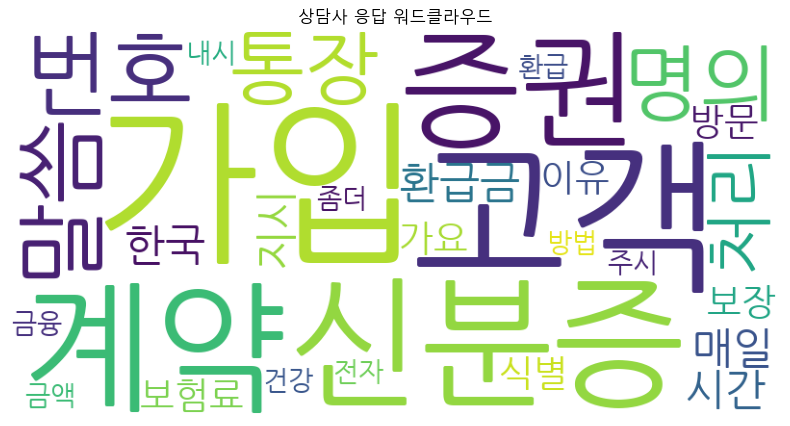

In [38]:
wc = WordCloud(font_path='NanumGothic.ttf', background_color='white', width=800, height=400)
plt.figure(figsize=(10,5))
plt.imshow(wc.generate_from_frequencies(dict(common_words)))
plt.axis('off')
plt.title("상담사 응답 워드클라우드")
plt.show()

In [39]:

# 데이터 준비
df = top_fall.copy()  # 두 데이터프레임 합치기
df["상담사응답"] = df["상담사응답"].astype(str)

# 형태소 분석
okt = Okt()
tokens = []
for text in df["상담사응답"]:
    nouns = okt.nouns(text)
    tokens.extend(nouns)

# 불용어 제거 (자주 등장하는 쓸모 없는 단어)
stopwords = ['고객님', '있습니다', '해드리겠습니다', '합니다', '하겠습니다', '안내', '상품', '수', '알', '무엇', '해지', '절차', '통화', '보험']
tokens = [t for t in tokens if t not in stopwords and len(t) > 1]

# 상위 단어 빈도수
count = Counter(tokens)
common_words = count.most_common(30)


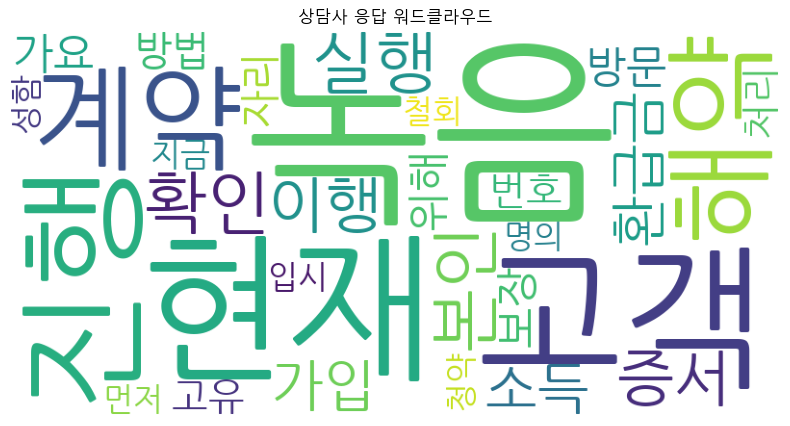

In [40]:
wc = WordCloud(font_path='NanumGothic.ttf', background_color='white', width=800, height=400)
plt.figure(figsize=(10,5))
plt.imshow(wc.generate_from_frequencies(dict(common_words)))
plt.axis('off')
plt.title("상담사 응답 워드클라우드")
plt.show()

In [41]:
import pandas as pd
from scipy.stats import chi2_contingency

# 교차표 데이터 구성
data = {
    "감정 상승": [1, 5, 8, 8, 6, 3],
    "감정 하락": [9, 34, 11, 11, 15, 1]
}
index = ["공감형", "기계형", "반문형", "조건강조형", "정보제공형", "설득형"]

df = pd.DataFrame(data, index=index)

# 카이제곱 독립성 검정
chi2_stat, p_value, dof, expected = chi2_contingency(df)

# 결과 출력
print("✅ 카이제곱 통계량 (chi2):", round(chi2_stat, 4))
print("✅ p-value:", round(p_value, 4))
print("✅ 자유도 (degrees of freedom):", dof)
print("\n[기대도수 (Expected Frequency)]")
print(pd.DataFrame(expected, index=index, columns=df.columns))


✅ 카이제곱 통계량 (chi2): 14.2964
✅ p-value: 0.0138
✅ 자유도 (degrees of freedom): 5

[기대도수 (Expected Frequency)]
           감정 상승      감정 하락
공감형     2.767857   7.232143
기계형    10.794643  28.205357
반문형     5.258929  13.741071
조건강조형   5.258929  13.741071
정보제공형   5.812500  15.187500
설득형     1.107143   2.892857
